## 1. Importing Necessary Dependencies

In [177]:
import pandas as pd
import numpy as np 

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx

## 2. Loading and Reading Dataset

In [178]:
bakery_df = pd.read_csv("Bakery.csv")
bakery_df.head()

,TransactionNo,Items,DateTime,Daypart,DayType
0,1,Bread,30-10-2016 09:58,Morning,Weekend
1,2,Scandinavian,30-10-2016 10:05,Morning,Weekend
2,2,Scandinavian,30-10-2016 10:05,Morning,Weekend
3,3,Hot chocolate,30-10-2016 10:07,Morning,Weekend
4,3,Jam,30-10-2016 10:07,Morning,Weekend


In [179]:
print("Dataset shape: ", bakery_df.shape)
print("Dataset size: ", bakery_df.size)

Dataset shape:  (20507, 5)
Dataset size:  102535


In [180]:
bakery_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionNo  20507 non-null  int64 
 1   Items          20507 non-null  object
 2   DateTime       20507 non-null  object
 3   Daypart        20507 non-null  object
 4   DayType        20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB


In [181]:
bakery_df["TransactionNo"].nunique()

9465

In [182]:
bakery_df.describe(include=object)

,Items,DateTime,Daypart,DayType
count,20507,20507,20507,20507
unique,94,9182,4,2
top,Coffee,02-05-2017 11:58,Afternoon,Weekday
freq,5471,12,11569,12807


In [183]:
bakery_df["DateTime"] = pd.to_datetime(bakery_df["DateTime"], dayfirst=True)

In [184]:
bakery_df["DateTime"].dt.date.min()

datetime.date(2016, 1, 11)

In [185]:
bakery_df["DateTime"].dt.date.max()

datetime.date(2017, 12, 3)

In [186]:
bakery_df.isnull().sum()

TransactionNo    0
Items            0
DateTime         0
Daypart          0
DayType          0
dtype: int64

#### Overview of this dataset: 

1. Total number of observations/records = 20507
2. Number of Columns = 5  (1- Numerical & 4 - Categorical)
    --- Transaction Number, Items, DateTime, Daypart , DayType
3. This dataset records every transaction happend at the bakery from 01/11/2016 - 12/03/2017. 
4. Also records time of the transaction and categorizes them into separate dayparts like Morning, Noon, Evening & Night
5. Unique Transactions = 9465
6. Null Cells/Missing Cells = 0
7. Number of unique Items on sale = 94

## 3. Data Exploration and Visualization

#### 3.1 Let's look for best sellers and frequent items.

In [187]:
itemFrequency = bakery_df["Items"].value_counts()
itemFrequency.head()

Items
Coffee    5471
Bread     3325
Tea       1435
Cake      1025
Pastry     856
Name: count, dtype: int64

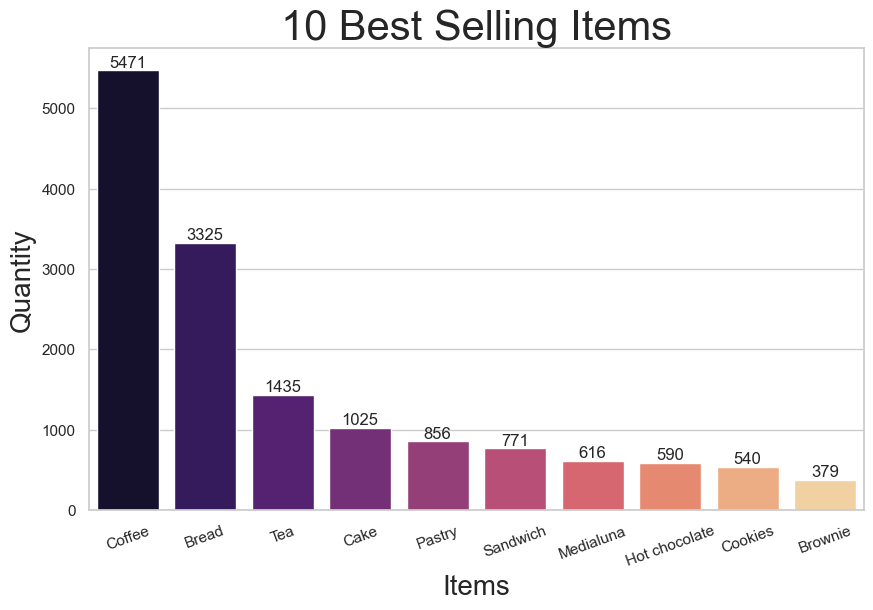

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))

ax = sns.barplot(x = itemFrequency.head(10).index, y = itemFrequency.head(10).values, hue=itemFrequency.head(10).index, palette="magma"
,legend = False)

for bar in ax.containers:
    ax.bar_label(bar)

plt.xlabel("Items", fontsize = 20)
plt.ylabel("Quantity", fontsize = 20)
plt.xticks(rotation = 20)

plt.title("10 Best Selling Items", fontsize = 30)
plt.show()


Coffee is the most sold item followed by bread and tea. 

#### 3.2 Let's look into the peak part of the day and exact hour of peak sales.

In [189]:
# Let's first look at peak sales Daypart and visualize it. 

peak_sales_daypart= bakery_df["Daypart"].value_counts()
peak_sales_daypart

Daypart
Afternoon    11569
Morning       8404
Evening        520
Night           14
Name: count, dtype: int64

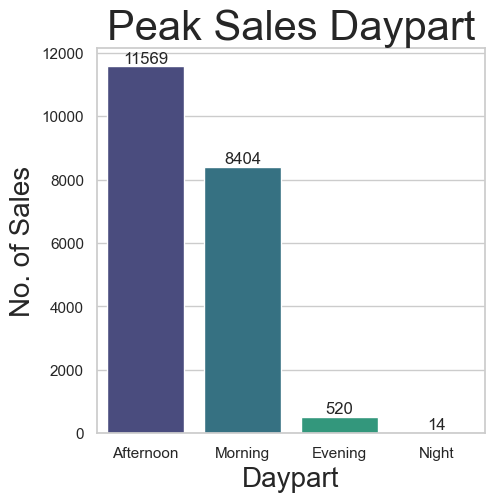

In [190]:
plt.figure(figsize=(5,5))

ax1 = sns.barplot(x = peak_sales_daypart.index, y = peak_sales_daypart.values, hue = peak_sales_daypart.index,
palette = 'viridis', legend = False)

plt.title("Peak Sales Daypart", fontsize = 30)
plt.xlabel("Daypart", fontsize = 20)
plt.ylabel("No. of Sales", fontsize = 20)

for bar in ax1.containers:
    ax1.bar_label(bar)
    
plt.show()

In [191]:
total_sales = 20507 # as we know from our initial data exploration. 
percentage_of_sales = ((peak_sales_daypart/total_sales)*100).round(2)
percentage_of_sales

Daypart
Afternoon    56.41
Morning      40.98
Evening       2.54
Night         0.07
Name: count, dtype: float64

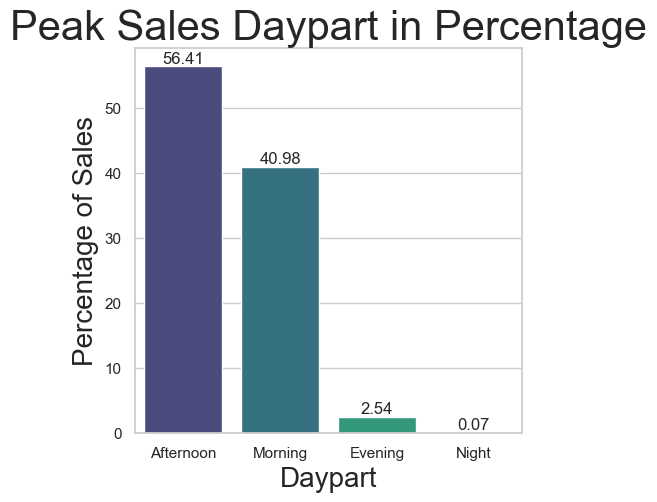

In [192]:
plt.figure(figsize=(5,5))

ax1 = sns.barplot(x = percentage_of_sales.index, y = percentage_of_sales.values, hue = percentage_of_sales.index,
palette = 'viridis', legend = False)

plt.title("Peak Sales Daypart in Percentage", fontsize = 30)
plt.xlabel("Daypart", fontsize = 20)
plt.ylabel("Percentage of Sales", fontsize = 20)

for bar in ax1.containers:
    ax1.bar_label(bar)
    
plt.show()

Afternoon seems to be the peak sales part of the day out of all, followed by morning. 

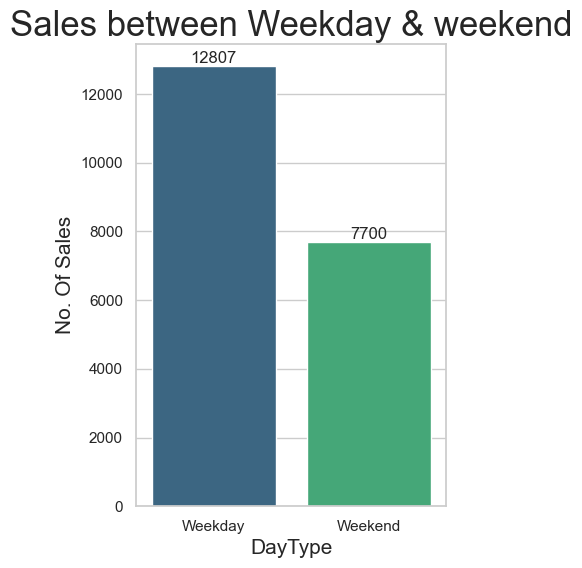

In [193]:
# Let's now visualize the sales between Weekend and Weekday. 

plt.figure(figsize = (4,6))

peak_sales_daytype = bakery_df["DayType"].value_counts()

ax2 = sns.barplot(x = peak_sales_daytype.index, y = peak_sales_daytype.values, hue = peak_sales_daytype.index,
palette = "viridis", legend = False)

for bar in ax2.containers:
    ax2.bar_label(bar)
plt.title("Sales between Weekday & weekend", fontsize = 25)
plt.xlabel('DayType', fontsize = 15)
plt.ylabel("No. Of Sales", fontsize = 15)

plt.show()

In [194]:
# Let's now track down the hour which sees the most sales across the entire dataset. 
# for that we must get the hour part out of the datetime column and then process it. 

In [195]:
peak_sales_hour_df = bakery_df["DateTime"].dt.hour.to_frame()
peak_sales_hour_df.head()

,DateTime
0,9
1,10
2,10
3,10
4,10


In [196]:
peak_sales_hour = peak_sales_hour_df.value_counts().head(10)
peak_sales_hour

DateTime
11          3102
12          2854
10          2666
14          2640
13          2617
15          2115
9           1966
16          1343
8            645
17           368
Name: count, dtype: int64

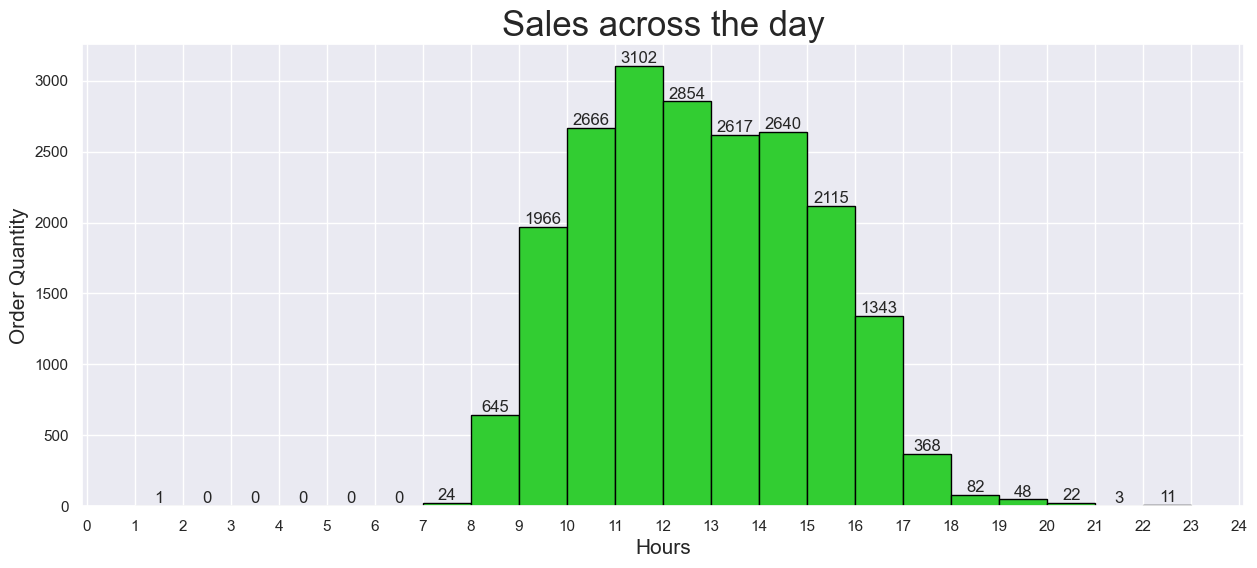

In [197]:
plt.figure(figsize=(15,6))

sns.set_theme(style= "darkgrid")

ax3 = sns.histplot(peak_sales_hour_df, binwidth=1, edgecolor="black", legend=False)

for containers in ax3.containers:
    if len(containers) > 0: 
        ax3.bar_label(containers)

plt.xticks(range(0,25, 1)) 

## Instead of making the code too complex, I have used the range(0,25,1) which 
## which represents the total hours in a day 0-24, with labelling at x-axis at every hour. 
# I could have also used range(df["DateTime"].max(), df["DateTime"].min()+1,1). 

for bar in ax3.patches:
    bar.set_facecolor("#32CD32")

plt.title("Sales across the day", fontsize = 25)
plt.xlabel("Hours", fontsize = 15)
plt.ylabel("Order Quantity", fontsize = 15)

plt.show()

As we can see from the above histogram plot, the peak sales start from morning 9 AM and lasts till 4 PM with 11 AM - 12 PM being the busiest hour.

In [198]:
# This observation includes data across a weekend. Let's now separate weekend from weekday to glance changes if any present. 

In [199]:
weekend_sales = bakery_df[bakery_df["DayType"]=="Weekend"]
weekend_sales

,TransactionNo,Items,DateTime,Daypart,DayType
0,1,Bread,2016-10-30 09:58:00,Morning,Weekend
1,2,Scandinavian,2016-10-30 10:05:00,Morning,Weekend
2,2,Scandinavian,2016-10-30 10:05:00,Morning,Weekend
3,3,Hot chocolate,2016-10-30 10:07:00,Morning,Weekend
4,3,Jam,2016-10-30 10:07:00,Morning,Weekend
...,...,...,...,...,...
20502,9682,Coffee,2017-09-04 14:32:00,Afternoon,Weekend
20503,9682,Tea,2017-09-04 14:32:00,Afternoon,Weekend
20504,9683,Coffee,2017-09-04 14:57:00,Afternoon,Weekend
20505,9683,Pastry,2017-09-04 14:57:00,Afternoon,Weekend


In [200]:
weekend_sales["Daypart"].value_counts()

Daypart
Afternoon    4296
Morning      3230
Evening       164
Night          10
Name: count, dtype: int64

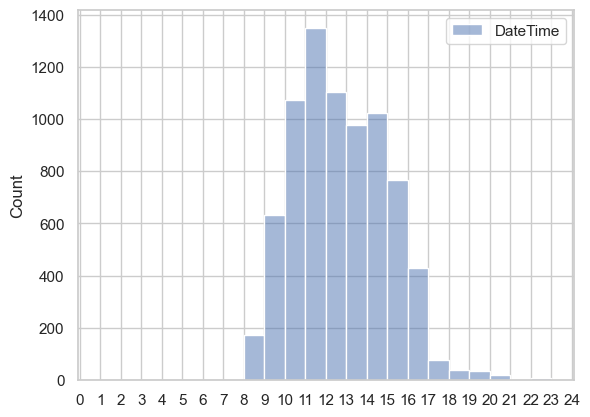

In [353]:
weekend_hourly_sale = weekend_sales["DateTime"].dt.hour.to_frame()

sns.histplot(weekend_hourly_sale, binwidth=1)
plt.xticks(range(0,25,1))
plt.show()

We can see that weekend sales also follow very similar pattern. 

#### 3.3 Let's now look at monthly and weekly sales

In [202]:
bakery_df.head()

,TransactionNo,Items,DateTime,Daypart,DayType
0,1,Bread,2016-10-30 09:58:00,Morning,Weekend
1,2,Scandinavian,2016-10-30 10:05:00,Morning,Weekend
2,2,Scandinavian,2016-10-30 10:05:00,Morning,Weekend
3,3,Hot chocolate,2016-10-30 10:07:00,Morning,Weekend
4,3,Jam,2016-10-30 10:07:00,Morning,Weekend


In [203]:
bakery_df["Day"] = bakery_df["DateTime"].dt.day_name()
bakery_df["Month"] = bakery_df["DateTime"].dt.month_name()
bakery_df["Year"] = bakery_df["DateTime"].dt.year

bakery_df.head()

,TransactionNo,Items,DateTime,Daypart,DayType,Day,Month,Year
0,1,Bread,2016-10-30 09:58:00,Morning,Weekend,Sunday,October,2016
1,2,Scandinavian,2016-10-30 10:05:00,Morning,Weekend,Sunday,October,2016
2,2,Scandinavian,2016-10-30 10:05:00,Morning,Weekend,Sunday,October,2016
3,3,Hot chocolate,2016-10-30 10:07:00,Morning,Weekend,Sunday,October,2016
4,3,Jam,2016-10-30 10:07:00,Morning,Weekend,Sunday,October,2016


In [204]:
monthly_sales = bakery_df.groupby("Month")["Items"].count().sort_values(ascending = False)
monthly_sales

Month
March        3220
November     3076
January      3027
February     2748
December     2647
April        1048
October      1041
May           924
July          741
June          739
August        700
September     596
Name: Items, dtype: int64

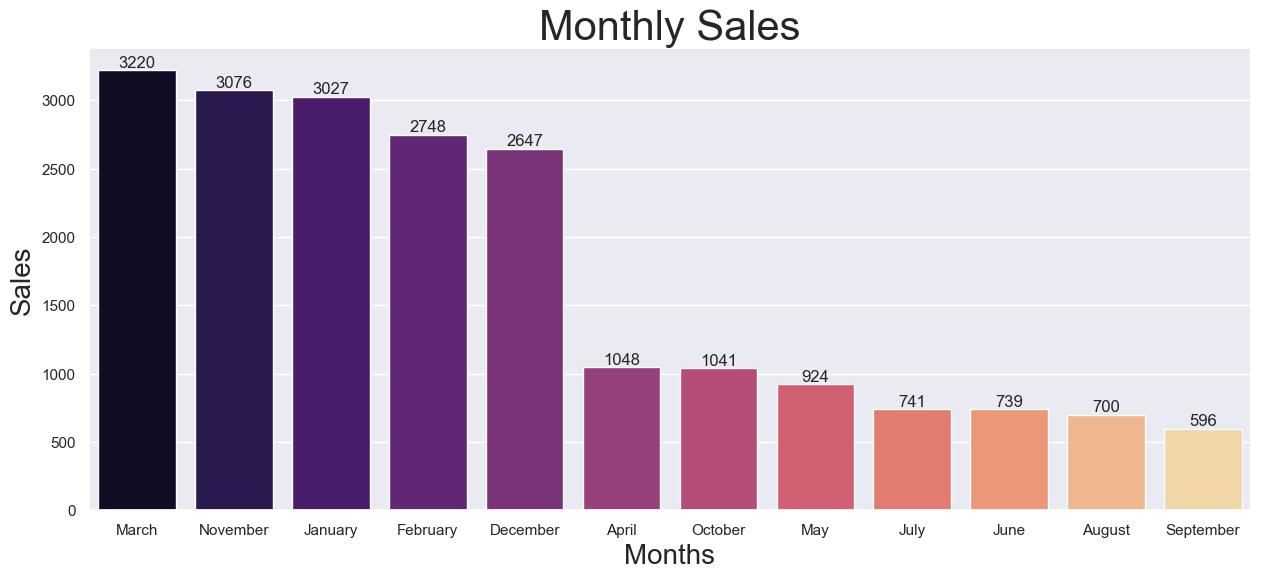

In [205]:
plt.figure(figsize= (15,6))

sns.set_theme(style = "darkgrid")

ax4 = sns.barplot(x= monthly_sales.index, y = monthly_sales.values, hue=monthly_sales.index, palette="magma", legend = False)

plt.title("Monthly Sales", fontsize = 30)
plt.xlabel("Months", fontsize = 20)
plt.ylabel("Sales", fontsize = 20)

for bar in ax4.containers:
    ax4.bar_label(bar)


plt.show()

Months from November to March sees the peak sales with March seeing the highest transactions. 

In [206]:
day_sales = bakery_df.groupby("Day")["Items"].count().sort_values(ascending = False)
day_sales

Day
Saturday     3554
Friday       3266
Sunday       3118
Monday       3035
Tuesday      2645
Thursday     2601
Wednesday    2288
Name: Items, dtype: int64

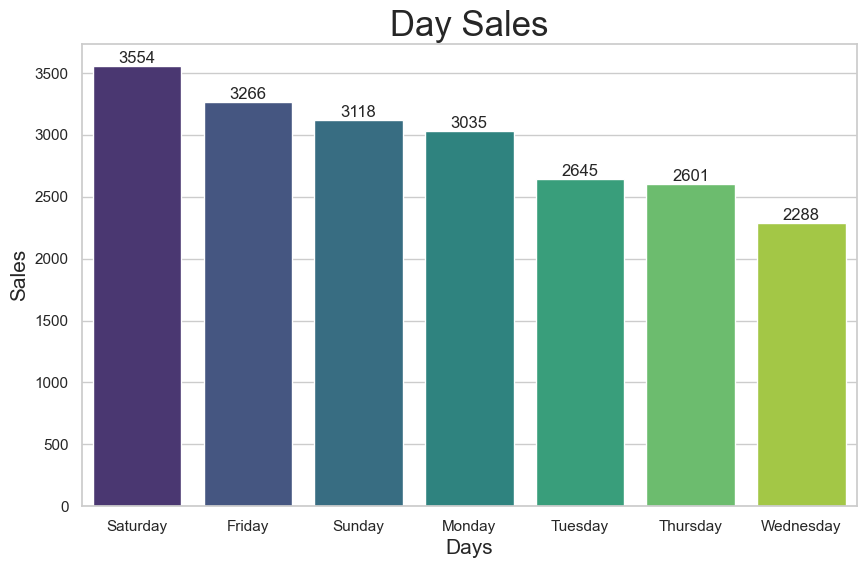

In [207]:
plt.figure(figsize=(10,6))
sns.set_theme(style = "whitegrid")

ax5 = sns.barplot(x = day_sales.index, y = day_sales.values, hue = day_sales.index, palette = 'viridis', legend= False)

for bar in ax5.containers:
    ax5.bar_label(bar)

plt.title("Day Sales", fontsize = 25)
plt.xlabel("Days", fontsize = 15)
plt.ylabel("Sales", fontsize = 15)

plt.show()

We can see that sales are high during weekends, and highest on Saturday. 

#### EDA Summary:
1. Coffee is the best selling item followed closely by Bread and Tea.
2. Bakery witnesses peak sales during weekends, peaking on Saturdays. 
3. Upon close observation, morning 10AM - Afternoon 3PM sees the highest sales numbers in any given day. Post which sales fell sharp. However, 
morning sales are also quite high but only 2nd to afternoon hours, with 11AM-12AM witnessing highest transactions. 
4. Across all those months, bakery sales sees surge during year-end and new year start from November - March. March sees the highest sales,     followed closely by November and January. 

## 4. Association Rules Generation

Now our task is to find how items are interrelated to each other. Which items complement each other in sales figures. 

#### 4.1 Data Preparation for Association Rule Mining

We will be using Apriori Algorithm to determine the items which are bought together the most. 
But this algo needs a dataframe with all the transactions one hot encoded for all items. 

To get that dataframe first we need a list of unique items bought in every single transaction in a list format. 

In [208]:
transactions = []

for items in bakery_df["TransactionNo"].unique(): 
    lst = list(set(bakery_df[bakery_df["TransactionNo"]==items]["Items"]))
    transactions.append(lst)
transactions[:10]

[['Bread'],
 ['Scandinavian'],
 ['Cookies', 'Hot chocolate', 'Jam'],
 ['Muffin'],
 ['Coffee', 'Pastry', 'Bread'],
 ['Medialuna', 'Pastry', 'Muffin'],
 ['Coffee', 'Medialuna', 'Pastry', 'Tea'],
 ['Bread', 'Pastry'],
 ['Bread', 'Muffin'],
 ['Medialuna', 'Scandinavian']]

Now we got the list, we need to convert this list to one hot encoded dataframe for that we will be using TransactionEncoder module from mlxtend library

In [209]:
from mlxtend.preprocessing import TransactionEncoder 
from mlxtend.frequent_patterns import apriori, association_rules

te = TransactionEncoder()
encodedData = te.fit(transactions).transform(transactions)
DF = pd.DataFrame(encodedData, columns= te.columns_)
DF.head()

## Here TransactionEncoder module converts list form data to an array datatype consisting of only boolean values. 
## te.fit(transactions) scans for all unique items in the transactions list and stores it as column values in te.columns_ variable. 
## .transform(transactions) then converts the data into one-hot encoded array which basically stores boolean values for all transactions. 
## In simple terms, this will output True for items present in the transactions and False for all the other unique items. 
## For example, let's say "Bread" is one transaction, then its corresponding one-hot encoded array will look like [False, True, False,......False]
## One true and rest 93 False values in that single array denoting a transaction. (94 unique items are being sold in the bakery).

## Once we get this array, its converted into a pandas dataframe, as we see below. 

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### 4.2 Association Rules Generation

In [210]:
# Let's now determine the frequently bought items/itemsets:

frequentItems = apriori(DF, use_colnames=True, min_support=0.02)
frequentItems

## Support here measures how often an item appears in the dataset or in this context, how often the item is bought. 
## If two items appear together, then support there means, also the same, how often that particular combo is bought. 

,support,itemsets
0,0.036344,(Alfajores)
1,0.327205,(Bread)
2,0.040042,(Brownie)
3,0.103856,(Cake)
4,0.478394,(Coffee)
5,0.054411,(Cookies)
6,0.039197,(Farm House)
7,0.058320,(Hot chocolate)
8,0.038563,(Juice)
9,0.061807,(Medialuna)


In [211]:
most_frequentItems = frequentItems.sort_values(by="support", ascending= False)
most_frequentItems.head(10)

## As we saw earlier during EDA, Coffee is the best selling item followed by Bread and Tea. 

,support,itemsets
4,0.478394,(Coffee)
1,0.327205,(Bread)
16,0.142631,(Tea)
3,0.103856,(Cake)
20,0.090016,"(Bread, Coffee)"
11,0.086107,(Pastry)
12,0.071844,(Sandwich)
9,0.061807,(Medialuna)
7,0.058320,(Hot chocolate)
23,0.054728,"(Coffee, Cake)"


Time for Association Rules

association_rules is basically a function which extracts rules (or a better term "relation") between two items. 
These items are called antecedents (the first item bought) and consequents (the 2nd item). This function uses all types of metrics
to gauge the relation between two items and it helps us understand how one item influences another item. Thereby helping us 
unearth patterns for better informed decision-making. 

In [233]:
rules = association_rules(frequentItems, metric= "lift", min_threshold=1)
rules.antecedents = rules.antecedents.apply(lambda x: next(iter(x)))
rules.consequents = rules.consequents.apply(lambda x: next(iter(x)))

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,Bread,Pastry,0.327205,0.086107,0.029160,0.089119,1.034977,1.0,0.000985,1.003306,0.050231,0.075908,0.003296,0.213884
1,Pastry,Bread,0.086107,0.327205,0.029160,0.338650,1.034977,1.0,0.000985,1.017305,0.036980,0.075908,0.017011,0.213884
2,Coffee,Cake,0.478394,0.103856,0.054728,0.114399,1.101515,1.0,0.005044,1.011905,0.176684,0.103745,0.011765,0.320679
3,Cake,Coffee,0.103856,0.478394,0.054728,0.526958,1.101515,1.0,0.005044,1.102664,0.102840,0.103745,0.093105,0.320679
4,Tea,Cake,0.142631,0.103856,0.023772,0.166667,1.604781,1.0,0.008959,1.075372,0.439556,0.106736,0.070090,0.197779
5,Cake,Tea,0.103856,0.142631,0.023772,0.228891,1.604781,1.0,0.008959,1.111865,0.420538,0.106736,0.100611,0.197779
6,Coffee,Cookies,0.478394,0.054411,0.028209,0.058966,1.083723,1.0,0.002179,1.004841,0.148110,0.055905,0.004818,0.288707
7,Cookies,Coffee,0.054411,0.478394,0.028209,0.518447,1.083723,1.0,0.002179,1.083174,0.081700,0.055905,0.076787,0.288707
8,Coffee,Hot chocolate,0.478394,0.058320,0.029583,0.061837,1.060311,1.0,0.001683,1.003749,0.109048,0.058333,0.003735,0.284542
9,Hot chocolate,Coffee,0.058320,0.478394,0.029583,0.507246,1.060311,1.0,0.001683,1.058553,0.060403,0.058333,0.055314,0.284542


Out of all these metrics, for simplicity and fast decision-making, we will focus only on metrics like Support,
Confidence and Lift. 

Support: Measures how frequently an item appears in transactions.

Confidence: Measures the probability of buying Item B given that Item A is purchased. It tells how often two 
items are bought together out of total transactions that include Item A.

Lift: Measures how much more likely Item B is bought when Item A is present, compared to when Item A is absent. 
A lift >1 means Item A increases the chances of buying Item B, a lift <1 means it decreases the chances, and a 
lift ≈1 means no effect (independent).

#### 4.3 Rules Visualization

In [234]:
import matplotlib.pyplot as plt
import networkx as nx

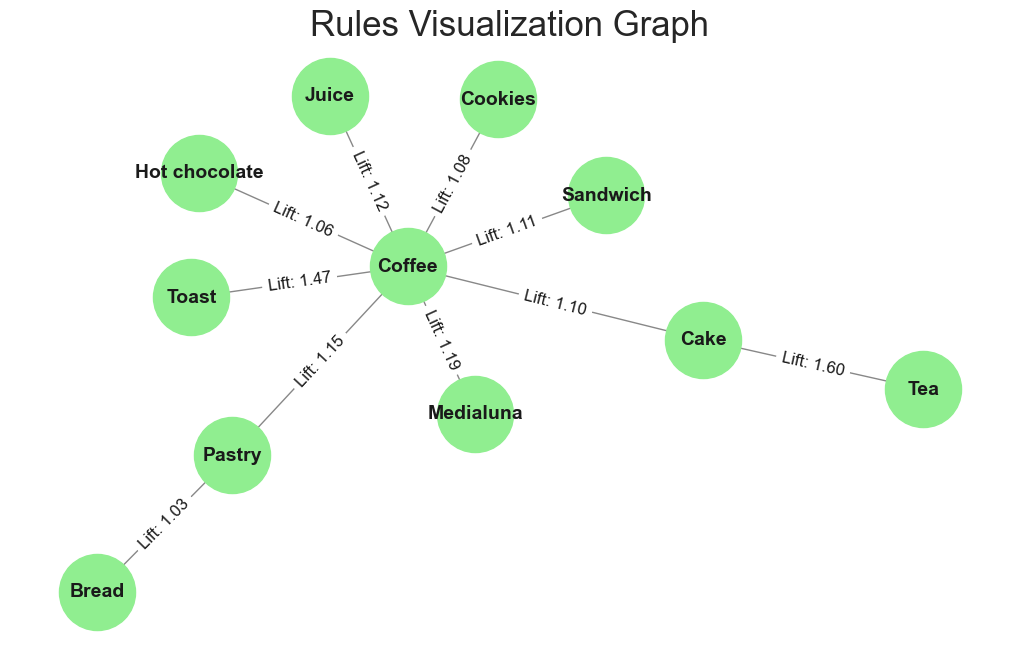

In [352]:
## This generates a graph from association rules
G = nx.Graph()        

# Adding nodes and edges from the association rules
for i, row in rules.iterrows():               
    G.add_edge(row["antecedents"], row["consequents"])

# Set the graph layout
pos = nx.spring_layout(G, k=0.8, dim=2, iterations = 1000)

# Draw the graph
plt.figure(figsize = (10,6))

nx.draw(G, pos, with_labels = True, node_size = 3000, node_color = "lightgreen", font_size = 14, 
font_weight = "bold", edge_color = "#888")

## Add edge labels 
edge_labels = {(row["antecedents"], row["consequents"]): f"Lift: {row["lift"] :.2f}" for _,
row in rules.iterrows() }

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size= 12)

plt.title("Rules Visualization Graph", fontsize = 25)

plt.show()

Let's understand the above block of code which gave us the graph visualization highlighting the relation 
between bakery items on sale. 

* 1st an empty undirected graph is generated using nx.Graph() method. 

* Since we have already created rules a dataframe only consisting of frequent items which have been filtered 
using lift metic and shown the most selling item combinations. 

* We use for loop using tuple unpacking to get antecedent and consequent from rules.iterrows() method one-by-one
and nodes and edges using the G.add_edge() method. 

* pos = nx.spring_layout() sets the graph layout which is to be drawn. 

* Here spring_layout ensures that nodes dont overlap and maintains high readability. 

* The name spring is derived from the concept of spring system, which is used here. The edges act as a spring 
connecting nodes which repel each other. 

* Within this method there are multiple parameters (k, dim, iterations):

k=0.5: Defines how far apart nodes should be. A lower k makes them closer together.

dim=2: Places nodes in a 2D space (since we are using a 2D plot).

iterations=400: Adjusts how many times the layout is refined. More iterations = better positioning.

* Then comes nx.draw() method which helps in drawing the graph, with all user-defined details. 

* At last, we add labels to the edge. That is we add Lift metric to the edge connecting two nodes containing
antecedent and consequent. 

* For this we use dictionary comprehension utilizing .iterrows() method to get all the needed info. 

#### Refinement Required:

Since coffee is the best selling item and has high support and confidence drawing muddy insights. We know 
coffee is highest selling item and can be combined with any item. So to get better relation between items, we 
will remove rows wherein coffee is the consequent, so that we will see relations between other items more clearly.

In [294]:
index_names = rules[rules["consequents"]=="Coffee"].index

refined_rules = rules.drop(index_names).sort_values(by="lift", ascending = False)

refined_rules.drop(["leverage", "conviction"], axis = 1, inplace = True)

refined_rules = refined_rules.reset_index()

refined_rules


,index,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,zhangs_metric,jaccard,certainty,kulczynski
0,4,Tea,Cake,0.142631,0.103856,0.023772,0.166667,1.604781,1.0,0.439556,0.106736,0.070090,0.197779
1,5,Cake,Tea,0.103856,0.142631,0.023772,0.228891,1.604781,1.0,0.420538,0.106736,0.100611,0.197779
2,18,Coffee,Toast,0.478394,0.033597,0.023666,0.049470,1.472431,1.0,0.615122,0.048464,0.016424,0.376936
3,12,Coffee,Medialuna,0.478394,0.061807,0.035182,0.073542,1.189878,1.0,0.305936,0.069665,0.012509,0.321387
4,14,Coffee,Pastry,0.478394,0.086107,0.047544,0.099382,1.154168,1.0,0.256084,0.091968,0.014526,0.325764
5,10,Coffee,Juice,0.478394,0.038563,0.020602,0.043065,1.116750,1.0,0.200428,0.041507,0.004683,0.288656
6,16,Coffee,Sandwich,0.478394,0.071844,0.038246,0.079947,1.112792,1.0,0.194321,0.074701,0.008731,0.306150
7,2,Coffee,Cake,0.478394,0.103856,0.054728,0.114399,1.101515,1.0,0.176684,0.103745,0.011765,0.320679
8,6,Coffee,Cookies,0.478394,0.054411,0.028209,0.058966,1.083723,1.0,0.148110,0.055905,0.004818,0.288707
9,8,Coffee,Hot chocolate,0.478394,0.058320,0.029583,0.061837,1.060311,1.0,0.109048,0.058333,0.003735,0.284542


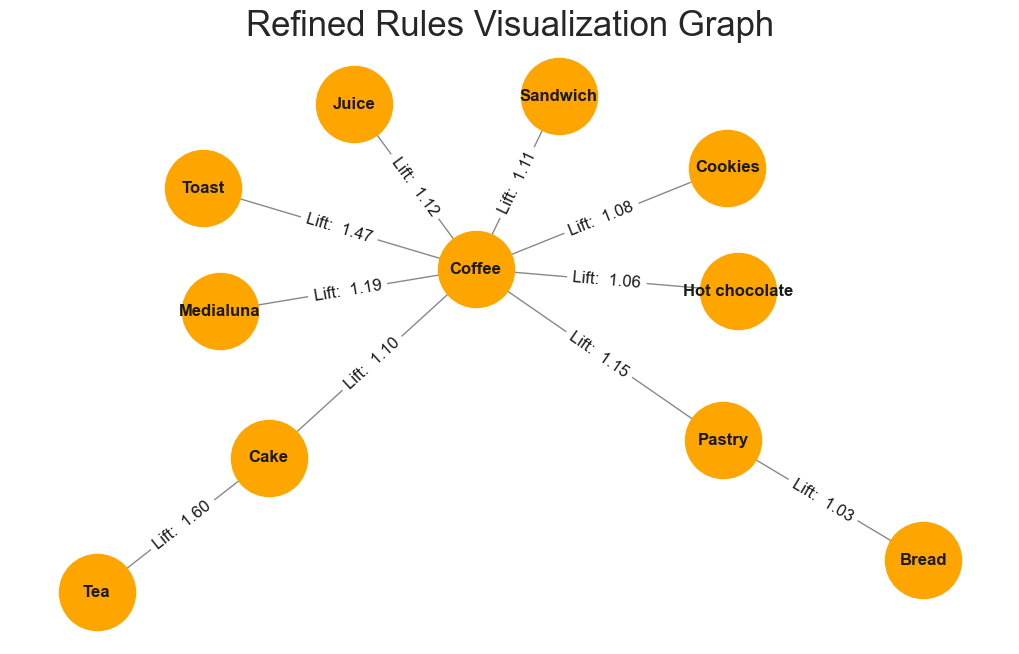

In [306]:
# Lets visualize the refined rules:

G = nx.Graph()

for i,row in refined_rules.iterrows():
    G.add_edge(row["antecedents"], row["consequents"])

pos = nx.spring_layout(G, k=0.8, dim=2, iterations = 1000)

plt.figure(figsize = (10,6))

nx.draw(G, pos, with_labels = True, node_size = 3000, node_color = "orange", font_size = 12, 
font_weight = "bold", edge_color = "#888")

# Add edge label 

edge_labels = { (row["antecedents"], row["consequents"]): f"Lift: {row["lift"]: .2f}" 
for _ , row in refined_rules.iterrows()} 

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

plt.title("Refined Rules Visualization Graph", fontsize = 25)

plt.show()